In [1]:
# # Content-based Image Retrieval using DCNNs
# ---------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import requests
from io import BytesIO
import cv2
from google.colab import files
import zipfile
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
class ImageDataset:
    """Class to create and manage our image dataset"""

    def __init__(self, base_dir='dataset'):
        self.base_dir = base_dir
        # Create directory if it doesn't exist
        os.makedirs(base_dir, exist_ok=True)
        self.categories = []
        self.image_paths = []
        self.labels = []

    def download_images(self, urls, category):
        """Download images from URLs for a specific category"""
        # Create category directory
        category_dir = os.path.join(self.base_dir, category)
        os.makedirs(category_dir, exist_ok=True)

        if category not in self.categories:
            self.categories.append(category)

        print(f"Downloading {len(urls)} images for category '{category}'...")

        for i, url in enumerate(urls):
            try:
                # Download image
                response = requests.get(url, timeout=10)
                img = Image.open(BytesIO(response.content))

                # Convert to RGB if in different format (like RGBA)
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Save the image
                img_path = os.path.join(category_dir, f"{category}_{i}.jpg")
                img.save(img_path)

                # Store image path and label
                self.image_paths.append(img_path)
                self.labels.append(self.categories.index(category))

            except Exception as e:
                print(f"Error downloading {url}: {e}")

    def add_from_upload(self, category):
        """Add images from user upload"""
        # Create category directory
        category_dir = os.path.join(self.base_dir, category)
        os.makedirs(category_dir, exist_ok=True)

        if category not in self.categories:
            self.categories.append(category)

        print(f"Upload images for category '{category}'")
        uploaded = files.upload()

        for filename, content in uploaded.items():
            try:
                # Save the uploaded image
                img = Image.open(BytesIO(content))

                # Convert to RGB if in different format
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Save the image
                img_path = os.path.join(category_dir, filename)
                img.save(img_path)

                # Store image path and label
                self.image_paths.append(img_path)
                self.labels.append(self.categories.index(category))

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    def create_sample_dataset(self):
        """Create a sample dataset with predefined categories and URLs"""
        # Sample image URLs for different categories
        categories = {
            'cats': [
                'https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg',
                'https://cdn.pixabay.com/photo/2014/04/13/20/49/cat-323262_1280.jpg',
                'https://cdn.pixabay.com/photo/2015/04/23/21/59/tree-736877_1280.jpg',
                'https://cdn.pixabay.com/photo/2017/07/25/01/22/cat-2536662_1280.jpg',
                'https://cdn.pixabay.com/photo/2016/03/28/12/35/cat-1285634_1280.jpg'
            ],
            'dogs': [
                'https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_1280.jpg',
                'https://cdn.pixabay.com/photo/2019/08/19/07/45/dog-4415649_1280.jpg',
                'https://cdn.pixabay.com/photo/2016/02/19/15/46/labrador-retriever-1210559_1280.jpg',
                'https://cdn.pixabay.com/photo/2016/05/09/10/42/weimaraner-1381186_1280.jpg',
                'https://cdn.pixabay.com/photo/2016/07/15/15/55/dachshund-1519374_1280.jpg'
            ],
            'flowers': [
                'https://cdn.pixabay.com/photo/2015/04/19/08/32/marguerite-729510_1280.jpg',
                'https://cdn.pixabay.com/photo/2018/02/08/22/27/flower-3140492_1280.jpg',
                'https://cdn.pixabay.com/photo/2014/04/14/20/11/pink-324175_1280.jpg',
                'https://cdn.pixabay.com/photo/2016/07/11/21/23/water-lily-1510707_1280.jpg',
                'https://cdn.pixabay.com/photo/2014/05/26/14/53/daisy-354973_1280.jpg'
            ],
            'cars': [
                'https://cdn.pixabay.com/photo/2015/05/28/23/12/auto-788747_1280.jpg',
                'https://cdn.pixabay.com/photo/2016/04/01/12/16/car-1300629_1280.png',
                'https://cdn.pixabay.com/photo/2016/02/13/13/11/oldtimer-1197800_1280.jpg',
                'https://cdn.pixabay.com/photo/2015/01/19/13/51/car-604019_1280.jpg',
                'https://cdn.pixabay.com/photo/2014/07/05/08/21/vw-beetle-384990_1280.jpg'
            ]
        }

        # Download images for each category
        for category, urls in categories.items():
            self.download_images(urls, category)

        print(f"Dataset created with {len(self.image_paths)} images across {len(self.categories)} categories")

    def import_dataset(self, zip_file_path):
        """Import dataset from a zip file"""
        # Create a temporary directory to extract the zip file
        temp_dir = os.path.join(self.base_dir, 'temp')
        os.makedirs(temp_dir, exist_ok=True)

        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        # Process the extracted files
        for root, dirs, files in os.walk(temp_dir):
            category = os.path.basename(root)

            if category == 'temp':
                continue

            if category not in self.categories:
                self.categories.append(category)

            category_dir = os.path.join(self.base_dir, category)
            os.makedirs(category_dir, exist_ok=True)

            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(category_dir, file)

                    # Copy the image
                    img = Image.open(src_path)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    img.save(dst_path)

                    # Store image path and label
                    self.image_paths.append(dst_path)
                    self.labels.append(self.categories.index(category))

        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

        print(f"Dataset imported with {len(self.image_paths)} images across {len(self.categories)} categories")

    def show_sample_images(self, n=10):
        """Display random sample images from the dataset"""
        if len(self.image_paths) == 0:
            print("No images in the dataset")
            return

        # Choose random images
        indices = np.random.choice(len(self.image_paths), min(n, len(self.image_paths)), replace=False)

        # Plot the images
        plt.figure(figsize=(15, 3*len(indices)//5 + 3))

        for i, idx in enumerate(indices):
            img_path = self.image_paths[idx]
            label = self.categories[self.labels[idx]]

            img = Image.open(img_path)
            plt.subplot(len(indices)//5 + 1, 5, i+1)
            plt.imshow(img)
            plt.title(f"{label}\n{os.path.basename(img_path)}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self.image_paths)

    def get_image_path(self, index):
        return self.image_paths[index]

    def get_label(self, index):
        return self.labels[index]

    def get_category(self, index):
        return self.categories[self.labels[index]]

In [4]:
 # Create and initialize the dataset
print("Creating dataset...")
dataset = ImageDataset(base_dir='cbir_dataset')
dataset.create_sample_dataset()

Creating dataset...
Error downloading https://cdn.pixabay.com/photo/2016/03/28/12/35/cat-1285634_1280.jpg: cannot identify image file <_io.BytesIO object at 0x7bd6040e0360>
Error downloading https://cdn.pixabay.com/photo/2014/05/26/14/53/daisy-354973_1280.jpg: cannot identify image file <_io.BytesIO object at 0x7bd6047b29d0>
Error downloading https://cdn.pixabay.com/photo/2014/07/05/08/21/vw-beetle-384990_1280.jpg: cannot identify image file <_io.BytesIO object at 0x7bd604746980>
Dataset created with 17 images across 4 categories



Sample images from the dataset:


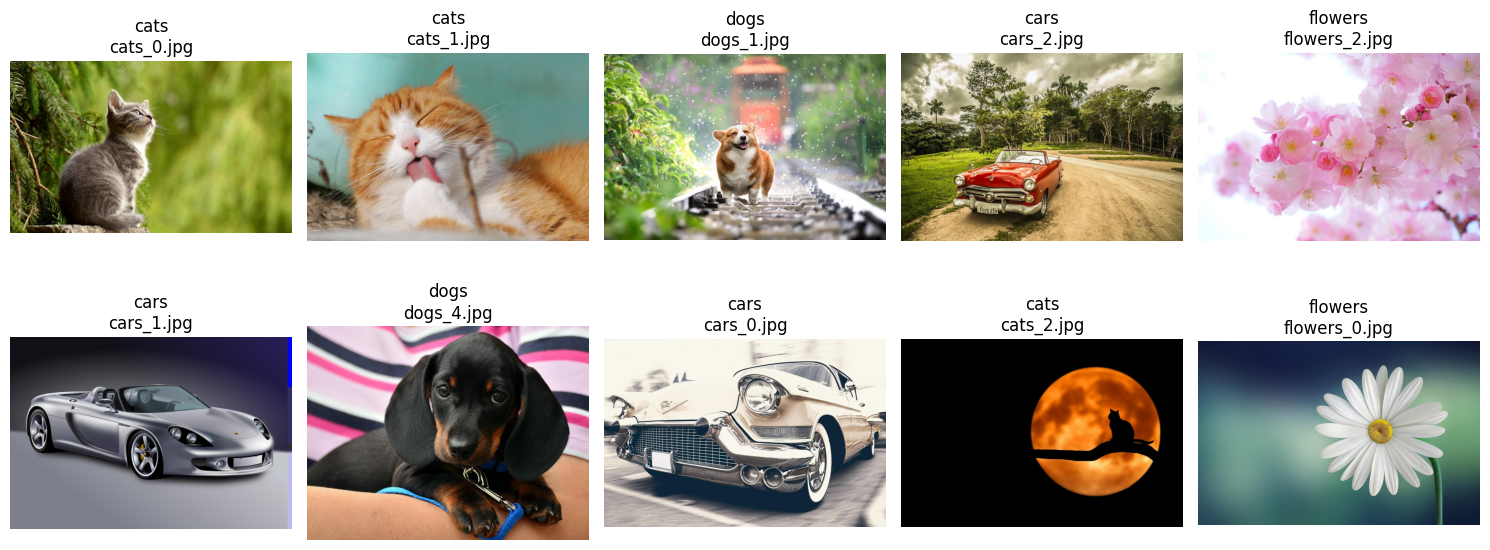

In [5]:
# Show sample images
print("\nSample images from the dataset:")
dataset.show_sample_images(10)

In [7]:
class FeatureExtractor:
    """Extract features from images using pre-trained DCNNs""" # capture both visual appearance and semantic content simultaneously.

    def __init__(self, model_name='vgg16', include_top=False, pooling='avg'):
        self.model_name = model_name.lower()

        # Load the pre-trained model
        if self.model_name == 'vgg16':
            self.base_model = VGG16(weights='imagenet', include_top=include_top, pooling=pooling)
            self.preprocess_func = vgg_preprocess
            self.input_shape = (224, 224)
        elif self.model_name == 'resnet50':
            self.base_model = ResNet50(weights='imagenet', include_top=include_top, pooling=pooling)
            self.preprocess_func = resnet_preprocess
            self.input_shape = (224, 224)
        else:
            raise ValueError(f"Unsupported model: {model_name}. Use 'vgg16' or 'resnet50'.")

        print(f"Loaded {model_name} model for feature extraction")

    def extract_features(self, img_path):
        """Extract features from a single image"""
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=self.input_shape)
        x = image.img_to_array(img) # Converts the image to a NumPy array.
        x = np.expand_dims(x, axis=0) # Adds a batch dimension (shape becomes (1, 224, 224, 3))
        x = self.preprocess_func(x)

        # Extract features
        features = self.base_model.predict(x, verbose=0) # Passes the image through the model to get the features.
        return features.flatten() # Flattens the feature map into a 1D vector and returns it.

    def extract_features_batch(self, image_paths, batch_size=32):
        """Extract features from a batch of images"""
        n_images = len(image_paths)
        n_batches = (n_images + batch_size - 1) // batch_size  # Ceiling division

        all_features = []

        for i in tqdm(range(n_batches)):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_images)
            batch_paths = image_paths[start_idx:end_idx]

            # Load and preprocess batch
            batch_images = []
            for img_path in batch_paths:
                try:
                    img = image.load_img(img_path, target_size=self.input_shape)
                    x = image.img_to_array(img)
                    batch_images.append(x)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    # Add a black image as placeholder
                    batch_images.append(np.zeros((*self.input_shape, 3)))

            # Convert to array and preprocess
            batch_array = np.array(batch_images)
            batch_array = self.preprocess_func(batch_array)

            # Extract features
            batch_features = self.base_model.predict(batch_array, verbose=0)
            all_features.extend(batch_features)

        return np.array(all_features)

In [8]:
# Initialize feature extractor
print("\nInitializing feature extractor...")
feature_extractor = FeatureExtractor(model_name='vgg16', include_top=False, pooling='avg')


Initializing feature extractor...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Loaded vgg16 model for feature extraction


In [9]:
class ImageRetrieval:
    """Retrieval system for finding similar images"""

    def __init__(self, dataset, feature_extractor):
        self.dataset = dataset
        self.feature_extractor = feature_extractor
        self.features = None

    def index_dataset(self):
        """Extract features for all images in the dataset"""
        print("Extracting features for all images in the dataset...")
        self.features = self.feature_extractor.extract_features_batch(self.dataset.image_paths)
        print(f"Indexed {len(self.features)} images")

    def find_similar(self, query_path, top_k=5):
        """Find similar images to the query image"""
        # Extract features from the query image
        query_features = self.feature_extractor.extract_features(query_path)
        query_features = query_features.reshape(1, -1)

        # Compute similarity
        similarities = cosine_similarity(query_features, self.features)[0]

        # Get top-k indices
        top_indices = np.argsort(similarities)[::-1][:top_k]

        # Return results
        results = []
        for idx in top_indices:
            results.append({
                'image_path': self.dataset.get_image_path(idx),
                'category': self.dataset.get_category(idx),
                'similarity': similarities[idx]
            })

        return results

    def retrieve_by_upload(self, top_k=5):
        """Retrieve similar images by uploading a query image"""
        print("Upload a query image:")
        uploaded = files.upload()

        # Get the first uploaded file
        query_path = None
        for filename, content in uploaded.items():
            # Save the uploaded image to a temporary file
            query_path = os.path.join('/tmp', filename)
            with open(query_path, 'wb') as f:
                f.write(content)
            break

        if query_path is None:
            print("No image uploaded")
            return

        # Find similar images
        results = self.find_similar(query_path, top_k)

        # Display results
        self.display_results(query_path, results)

        return results

    def retrieve_by_index(self, index, top_k=5):
        """Retrieve similar images by using an image from the dataset"""
        if index < 0 or index >= len(self.dataset):
            print(f"Invalid index. Valid range: 0-{len(self.dataset)-1}")
            return

        # Get the query image
        query_path = self.dataset.get_image_path(index)

        # Find similar images
        results = self.find_similar(query_path, top_k+1)  # +1 because the image itself will be included

        # Filter out the query image if it's in the results
        results = [r for r in results if r['image_path'] != query_path][:top_k]

        # Display results
        self.display_results(query_path, results)

        return results

    def display_results(self, query_path, results):
        """Display the query image and retrieved results"""
        n_results = len(results)

        plt.figure(figsize=(15, 4 + n_results * 3))

        # Display query image
        plt.subplot(1 + n_results, 2, 1)
        query_img = Image.open(query_path)
        plt.imshow(query_img)
        plt.title("Query Image\n" + os.path.basename(query_path))
        plt.axis('off')

        # Display results
        for i, result in enumerate(results):
            plt.subplot(1 + n_results, 2, 3 + i*2)
            img = Image.open(result['image_path'])
            plt.imshow(img)
            plt.title(f"Result {i+1}: {result['category']}\n"
                     f"Similarity: {result['similarity']:.4f}\n"
                     f"{os.path.basename(result['image_path'])}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [10]:
# Initialize image retrieval system
print("\nSetting up image retrieval system...")
retrieval_system = ImageRetrieval(dataset, feature_extractor)


Setting up image retrieval system...


In [11]:
# Index the dataset
print("\nIndexing the dataset...")
retrieval_system.index_dataset()


Indexing the dataset...
Extracting features for all images in the dataset...


100%|██████████| 1/1 [00:10<00:00, 10.45s/it]

Indexed 17 images



Retrieving similar images to a random image from the dataset...


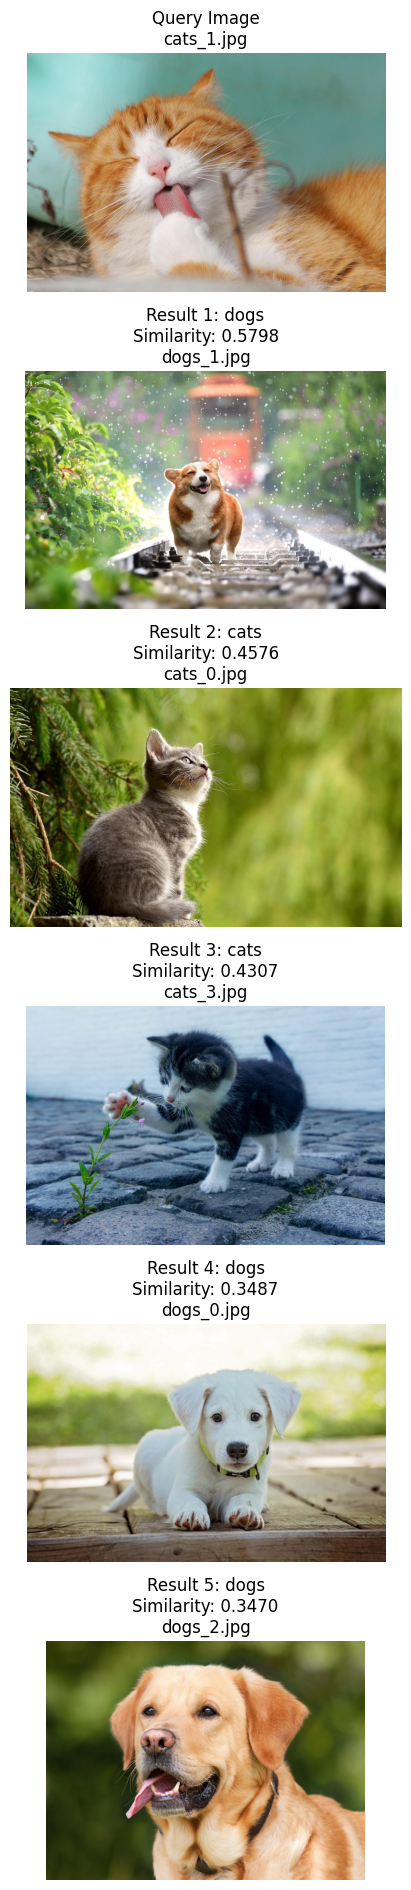

[{'image_path': 'cbir_dataset/dogs/dogs_1.jpg',
  'category': 'dogs',
  'similarity': np.float32(0.57980347)},
 {'image_path': 'cbir_dataset/cats/cats_0.jpg',
  'category': 'cats',
  'similarity': np.float32(0.4575728)},
 {'image_path': 'cbir_dataset/cats/cats_3.jpg',
  'category': 'cats',
  'similarity': np.float32(0.43068677)},
 {'image_path': 'cbir_dataset/dogs/dogs_0.jpg',
  'category': 'dogs',
  'similarity': np.float32(0.34869662)},
 {'image_path': 'cbir_dataset/dogs/dogs_2.jpg',
  'category': 'dogs',
  'similarity': np.float32(0.3470474)}]

In [12]:
# Perform retrieval by index
print("\nRetrieving similar images to a random image from the dataset...")
random_idx = np.random.randint(len(dataset))
retrieval_system.retrieve_by_index(random_idx, top_k=5)


Upload an image to find similar images...
Upload a query image:


Saving pexels-mayday-1545743.jpg to pexels-mayday-1545743.jpg


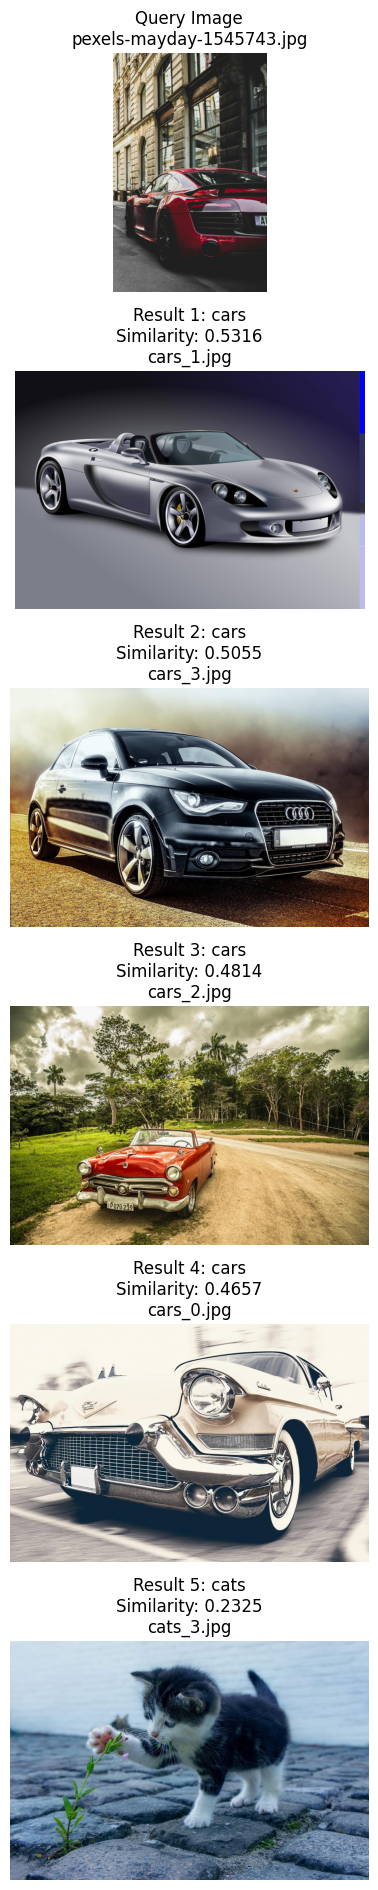


Content-based Image Retrieval system is ready!


In [15]:
# Perform retrieval by upload
print("\nUpload an image to find similar images...")
retrieval_system.retrieve_by_upload(top_k=5)
print("\nContent-based Image Retrieval system is ready!")